# CNN-based Brain Tumour Segmentation Network
## Import packages
Please make sure you have all the required packages installed. 

In [45]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os


from tqdm import tqdm
from sklearn.metrics import accuracy_score
import shutil
import tensorflow as tf
import keras
import cv2

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import random_rotation, random_shift, random_zoom


from glob import glob
from PIL import Image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.layers import Input, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Visualise MRI Volume Slices and Segmentation Maps
Each MRI image contains information about a three-dimensional (3D) volume of space. An MRI image is composed of a number of voxels, which is like pixels in 2D images. Here we visualise the transverse plane (usually has a higher resolution) of some of the volumes and the corresponding segmentation maps.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


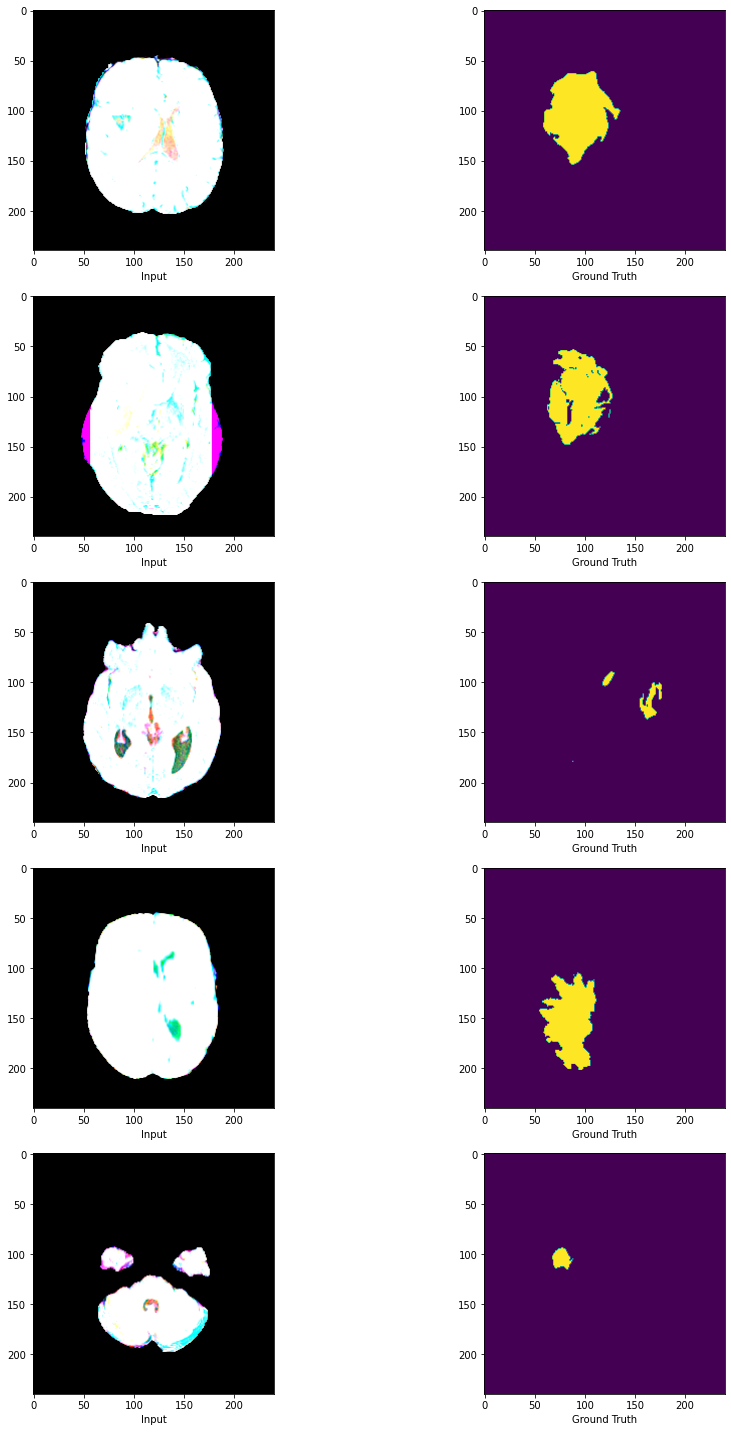

In [46]:
def plot_samples(x,n=20):
    i = n
    j = 2
    plt.figure(figsize=(15,20))
    k = 1
    idx_nums = np.random.randint(len(x),size=n)
    for idx in idx_nums:
        plt.subplot(i,j,k)
        while k%2 != 0:
            plt.imshow(np.load(x[idx]))
            # plt.imshow(np.load(x[idx])[:,:,0], cmap='gray')#读取输入图像
            plt.xlabel("Input")
            k += 1
        plt.subplot(i,j,k)
        plt.imshow(np.load(x[idx].split('_')[0]+'_seg.npy'))
        # plt.imshow(np.load(x[idx].split('_')[0]+'_seg.npy')[:,:], cmap='gray')#读取字符串（以_为分割 读取之前的字符串,然后拼接后面的_seg.npy）其实就是读取了输入之后,再读取对应的seg的文件名
        plt.xlabel("Ground Truth")
        k += 1
    plt.tight_layout()
    plt.show()

img_path = 'Dataset/'
img_list = []
# CLASS = 'No'
# all_files = os.listdir(img_path + CLASS)
all_files = os.listdir(img_path)
files = [item for item in all_files if "img" in item]
random.shuffle(files)
img_num = len(files)
for (n, file_name) in enumerate(files):
    # img = os.path.join(img_path,CLASS,file_name)
    # seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
    img = os.path.join(img_path,file_name)
    seg = os.path.join(img_path,file_name.split('_')[0]+'_seg.npy')
    img_list.append(img)
plot_samples(img_list, n=5)

## Data preprocessing (Optional)

Images in the original dataset are usually in different sizes, so sometimes we need to resize and normalise (z-score is commonly used in preprocessing the MRI images) them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods. If preprocessing methods like cropping is applied, remember to convert the segmentation result back to its original size. 


## Split your dataset into training and validation
Validation dataset would not be used to train your network, it is normally for evaluating your model performance and choosing the best set of hyperparameters. Choose the size of your training and validation set yourself.

这段代码主要用来将图像数据集分为训练集和验证集。首先,它在本地创建了名为 "Train" 和 "Val" 的文件夹,并在其中创建了 "Yes" 和 "No" 两个子文件夹。然后,它读取了 "Dataset" 文件夹中的所有图像,并随机打乱了文件名顺序。对于每个类别中的图像,它使用 80% 的图像作为训练集,剩余的 20% 作为验证集。然后它把这些图像复制到了训练集和验证集文件夹中。

In [47]:
#uncomment if using linux/macos
!rm -rf Train Val Train_label Val_label
!mkdir Train Val 


img_path = 'Dataset/'

#需要删除Dataset中的Yes和No的时候用,运行第一次 删除后 即可注释掉

for subdir, dirs, files in os.walk('Dataset/'):
    for file in files:
        file_path = subdir + os.sep + file
        if 'Yes' in file_path or 'No' in file_path:
            file_path_new = file_path.replace('Yes/', '').replace('No/', '')
            shutil.move(file_path, file_path_new)
shutil.rmtree('Dataset/Yes')
shutil.rmtree('Dataset/No')

train_list = []
val_list = []
# train_lab_list = []
# val_lab_list = []
all_files = os.listdir(img_path)
files = [item for item in all_files if "img" in item]
img_num = len(files)
random.shuffle(files)
# 在这里,对于 files 列表中的每个文件名 file_name,都会计算一个索引值 n,从 0 开始
# 并将这个索引和文件名作为元组（n, file_name）传给循环变量。
# 这样,在循环体内部就可以很方便地使用文件名和索引值了。
for (n, file_name) in enumerate(files):
    img = os.path.join(img_path,file_name)
    seg = os.path.join(img_path,file_name.split('_')[0]+'_seg.npy')
    # 80% of images will be used for training, change the number here 
    # to use different number of images for training your model.
    if n < 0.8*img_num:
        shutil.copy(img, os.path.join('Train/',file_name))
        train_list.append(os.path.join('Train/',file_name))#拼接路径放置到变量train_list中
        shutil.copy(seg, os.path.join('Train/',file_name.split('_')[0]+'_seg.npy'))
        # train_list.append(os.path.join('Train/',file_name.split('_')[0]+'seg.npy'))#拼接路径放置到变量train_list中
    else:
        shutil.copy(img, os.path.join('Val/',file_name))
        val_list.append(os.path.join('Val/',file_name))
        shutil.copy(seg, os.path.join('Val/',file_name.split('_')[0]+'_seg.npy'))
        # val_list.append(os.path.join('Val/',file_name.split('_')[0]+'seg.npy'))#拼接路径放置到变量Val_list中

## Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose in this projects including rotation, shifting, flipping, etc.

You are encouraged to try different augmentation method to get the best segmentation result.


## Get the data generator ready

In [48]:
import tensorflow
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=16, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_channels1=1
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def apply_augmentation(self,img, seg): 
        # Generate random rotation angle 
        angle = np.random.uniform(-45, 45) 
        scale = 1.0 
        rows, cols = img.shape[:2] 
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, scale) 
        img = cv2.warpAffine(img, M, (cols, rows)) 
        seg= cv2.warpAffine(seg, M, (cols, rows))
        # Apply random flipping 
        if np.random.random() < 0.5: 
            img = np.fliplr(img) 
            seg = np.fliplr(seg) 
        # Apply random zooming 
        scale = np.random.uniform(0.5, 1.2) 
        rows, cols = img.shape[:2] 
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 0, scale) 
        img = cv2.warpAffine(img, M, (cols, rows)) 
        seg = cv2.warpAffine(seg, M, (cols, rows))

        return img, seg
        
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels),dtype='float32')
        y = np.empty((self.batch_size,*self.dim),dtype='float32')

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            x =np.load(ID)
            y_ = np.load(ID.split('_')[0]+'_seg.npy')
            x,y_ = self.apply_augmentation(x,y_)
            X[i,]=x
            y[i,]=y_
        return X,y
# print(np.load(os.path.join('Train/','0_seg.npy')).dtype) #显示是uint8,不需要进行额外的OneHot处理
train_generator = DataGenerator(train_list)#train_list当作list_IDs,作为参数传入
validation_generator = DataGenerator(val_list)
img_size = (240,240)

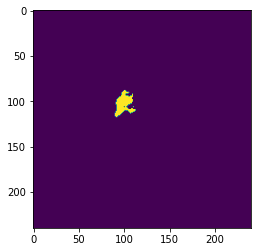

In [62]:
for j in range(validation_generator.batch_size):
    x_batch, y_batch = validation_generator[0]
    plt.imshow(y_batch[0,:,:])

## Define a metric for the performance of the model
Dice score is used here to evaluate the performance of your model.
More details about the Dice score and other metrics can be found at 
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2. Dice score can be also used as the loss function for training your model.

这段代码定义了两个函数:dice_coef和dice_coef_loss。dice_coef函数实现了Dice系数的计算,在这里是将预测结果与真实结果展平,然后计算交集,最后使用Dice系数公式计算结果。

dice_coef_loss函数将dice_coef函数的结果作为损失返回。

最后,在model.compile()中使用dice_coef_loss作为损失函数,并使用dice_coef作为模型的指标来编译模型,这样就可以在训练过程中使用Dice系数来评估模型的性能了。

## Build your own model here
The U-Net (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) structure is widely used for the medical image segmentation task. You can build your own model or modify the UNet by changing the hyperparameters for our task. If you choose to use Keras, more information about the Keras layers including Conv2D, MaxPooling and Dropout can be found at https://keras.io/api/layers/.

In [56]:
class U_Net():
    def __init__(self):
        # 设置图片基本参数
        self.height = 240
        self.width = 240
        self.channels = 3
        self.shape = (self.height, self.width, self.channels)

        # 优化器
        optimizer = Adam(0.002, 0.5)

        # u_net
        self.unet = self.build_unet()  # 创建网络变量
        self.unet.compile(loss='mse',
                          optimizer=optimizer,
                          metrics=[self.metric_fun])
        self.unet.summary()

    def build_unet(self, n_filters=16, dropout=0.1, batchnorm=True, padding='same'):

        # 定义一个多次使用的卷积块
        def conv2d_block(input_tensor, n_filters=16, kernel_size=3, batchnorm=True, padding='same'):
            # the first layer
            x = Conv2D(n_filters, kernel_size, padding=padding)(
                input_tensor)
            if batchnorm:
                x = BatchNormalization()(x)
            x = Activation('relu')(x)

            # the second layer
            x = Conv2D(n_filters, kernel_size, padding=padding)(x)
            if batchnorm:
                x = BatchNormalization()(x)
            X = Activation('relu')(x)
            return X

        # 构建一个输入
        img = Input(shape=self.shape)

        # contracting path
        c1 = conv2d_block(img, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
        p1 = MaxPooling2D((2, 2))(c1)
        p1 = Dropout(dropout * 0.5)(p1)

        c2 = conv2d_block(p1, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)
        p2 = MaxPooling2D((2, 2))(c2)
        p2 = Dropout(dropout)(p2)

        c3 = conv2d_block(p2, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)
        p3 = MaxPooling2D((2, 2))(c3)
        p3 = Dropout(dropout)(p3)

        c4 = conv2d_block(p3, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm, padding=padding)
        p4 = MaxPooling2D((2, 2))(c4)
        p4 = Dropout(dropout)(p4)

        c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm, padding=padding)

        # extending path
        u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
        u6 = concatenate([u6, c4])
        u6 = Dropout(dropout)(u6)
        c6 = conv2d_block(u6, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm, padding=padding)

        u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
        u7 = concatenate([u7, c3])
        u7 = Dropout(dropout)(u7)
        c7 = conv2d_block(u7, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)

        u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c2])
        u8 = Dropout(dropout)(u8)
        c8 = conv2d_block(u8, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)

        u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
        u9 = concatenate([u9, c1])
        u9 = Dropout(dropout)(u9)
        c9 = conv2d_block(u9, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)

        output = Conv2D(1, (1, 1), activation='sigmoid')(c9)

        return Model(img, output)

    def metric_fun(self, y_true, y_pred):
        fz = tf.reduce_sum(2 * y_true * tf.cast(tf.greater(y_pred, 0.1), tf.float32)) + 1e-8
        fm = tf.reduce_sum(y_true + tf.cast(tf.greater(y_pred, 0.1), tf.float32)) + 1e-8
        return fz / fm

    def train(self, epochs=1, batch_size=32):
        os.makedirs('./weights', exist_ok=True)
        # 设置训练的checkpoint
        callbacks = [EarlyStopping(patience=10, verbose=2),
                     ReduceLROnPlateau(factor=0.5, patience=10, min_lr=0.00005, verbose=2),
                     ModelCheckpoint('./weights/best_model.h5', verbose=2, save_best_only=True)]
          # 进行训练
        # results = self.unet.fit_generator(train_generator,batch_size=batch_size, epochs=epochs, verbose=2,
        #                                     callbacks=callbacks, validation_split=0.1, shuffle=True)
        results = self.unet.fit(train_generator,
                                steps_per_epoch=len(train_generator),
                                validation_data= validation_generator,
                                epochs=90,
                                validation_steps=len(validation_generator),
                                callbacks=callbacks
                                )

        # 绘制损失曲线
        loss = results.history['loss']
        val_loss = results.history['val_loss']
        metric = results.history['metric_fun']
        val_metric = results.history['val_metric_fun']
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        x = np.linspace(0, len(loss), len(loss))  # 创建横坐标
        plt.subplot(121), plt.plot(x, loss, x, val_loss)
        plt.title("Loss curve"), plt.legend(['loss', 'val_loss'])
        plt.xlabel("Epochs"), plt.ylabel("loss")
        plt.subplot(122), plt.plot(x, metric, x, val_metric)
        plt.title("metric curve"), plt.legend(['metric', 'val_metric'])
        plt.xlabel("Epochs"), plt.ylabel("Dice")
        plt.show()  # 会弹出显示框,关闭之后继续运行
        fig.savefig('./evaluation/curve.png', bbox_inches='tight', pad_inches=0.1)  # 保存绘制曲线的图片
        plt.close()

    def contrast(self, batch_size=1):
        os.makedirs('./evaluation/test_result', exist_ok=True)
        self.unet.load_weights(r"weights/best_model.h5")
        test_num = len(validation_generator)
        index, step = 0, 0
        self.unet.evaluate(validation_generator,steps=test_num,verbose=2)
        n = 0.0
        while index < test_num:
            print('schedule: %d/%d' % (index, test_num))
            step += 1  # 记录训练批数
            
            # for i in range(index):
            x_batch, y_batch = validation_generator[index]

            mask = self.unet.predict(x_batch) > 0.5
            print(np.max(y_batch))
            mask_true = y_batch[0,:,:]
            
            if (np.sum(mask) > 0) == (np.sum(mask_true) > 0):
                n += 1
            mask = Image.fromarray(np.uint8(mask[0,:,:,0] * 255))
            mask.save('./evaluation/test_result/' + str(step) + '.png')
            print(mask_true)
            image = Image.fromarray(np.uint8(mask_true * 255))
            if image is None:
                print("Image.fromarray failed to decode image array")
            else:
                print("Image.fromarray successfully decoded image array")
            mask_true = Image.fromarray(np.uint8(mask_true * 255))
            mask_true.save('./evaluation/test_result/' + str(step) + 'true.png')
            index += batch_size
        acc = n / test_num * 100
        print('the accuracy of test data is: %.2f%%' % acc)

## Train your model here
Once you defined the model and data generator, you can start training your model.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 240, 240, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 240, 240, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 240, 240, 16) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

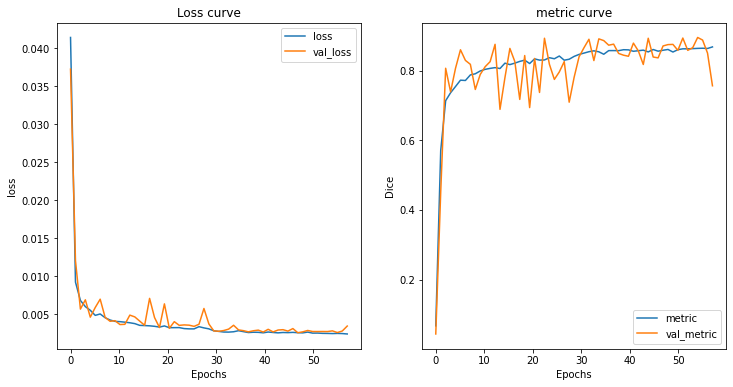

In [9]:
if __name__ == '__main__':
    unet = U_Net()
    unet.train()    # 开始训练网络

In [57]:
if __name__ == '__main__':
    unet = U_Net()
    unet.contrast()   # 评价测试集并检测测试集肿瘤分割结果

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 240, 240, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_126 (BatchN (None, 240, 240, 16) 64          conv2d_133[0][0]                 
__________________________________________________________________________________________________
activation_126 (Activation)     (None, 240, 240, 16) 0           batch_normalization_126[0][0]    
____________________________________________________________________________________________

## Save the model
Once your model is trained, remember to save it for testing.

## Save the test npy


## Run the model on the test set
After your last Q&A session, you will be given the test set. Run your model on the test set to get the segmentation results and submit your results in a .zip file. If the MRI image is named '100_img.npy', save your segmentation result as '100_seg.npy'. 

In [52]:
img_path = 'test/'
n = 1

result_path = 'test_result/'
if not os.path.exists(result_path):
    os.makedirs(result_path)

model = load_model('./weights/best_model.h5', custom_objects={'metric_fun': unet.metric_fun})
files = [f for f in os.listdir(img_path) if "_img.npy" in f]
img_num = len(files)

for (n, file_name) in enumerate(files):
    image = np.load(os.path.join(img_path, file_name))
    # image = tf.image.resize(image, (240,240))
    # image = tf.expand_dims(image, axis=0)
    seg = model.predict(image)
    seg_file_name = file_name.replace('_img.npy', '_seg.npy')
    np.save(os.path.join(result_path, seg_file_name), seg[0])
    n=n+1
    # print('save '+ file_name + ' as ' + seg_file_name)
    print('Saved the result of test:'+ str(n) +' in '+str(img_num))

Saved the result of test:1 in 1183
Saved the result of test:2 in 1183
Saved the result of test:3 in 1183
Saved the result of test:4 in 1183
Saved the result of test:5 in 1183
Saved the result of test:6 in 1183
Saved the result of test:7 in 1183
Saved the result of test:8 in 1183
Saved the result of test:9 in 1183
Saved the result of test:10 in 1183
Saved the result of test:11 in 1183
Saved the result of test:12 in 1183
Saved the result of test:13 in 1183
Saved the result of test:14 in 1183
Saved the result of test:15 in 1183
Saved the result of test:16 in 1183
Saved the result of test:17 in 1183
Saved the result of test:18 in 1183
Saved the result of test:19 in 1183
Saved the result of test:20 in 1183
Saved the result of test:21 in 1183
Saved the result of test:22 in 1183
Saved the result of test:23 in 1183
Saved the result of test:24 in 1183
Saved the result of test:25 in 1183
Saved the result of test:26 in 1183
Saved the result of test:27 in 1183
Saved the result of test:28 in 1183
S

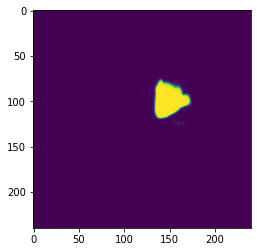

In [53]:
# plt.imshow(np.load('./test/0_img.npy'))
plt.imshow(np.load('./test_result/2544_seg.npy'))